# Problema de Negócio

A BrFinancial é uma financeira que atua em pequenos emprestimos.

Trouxe até a equipe de ciência de dados o problema de analíse comportamental dos clientes.

A equipe de dados, traçou um plano para prever se o cliente será pontual no seu pagamento ou não, tendo como base os atributos já conhecidos do cliente.

Objetivo:
A partir dos atributos apresentados é possível entender as características dos clientes, bem como a performance (inadimplência dos mesmos).


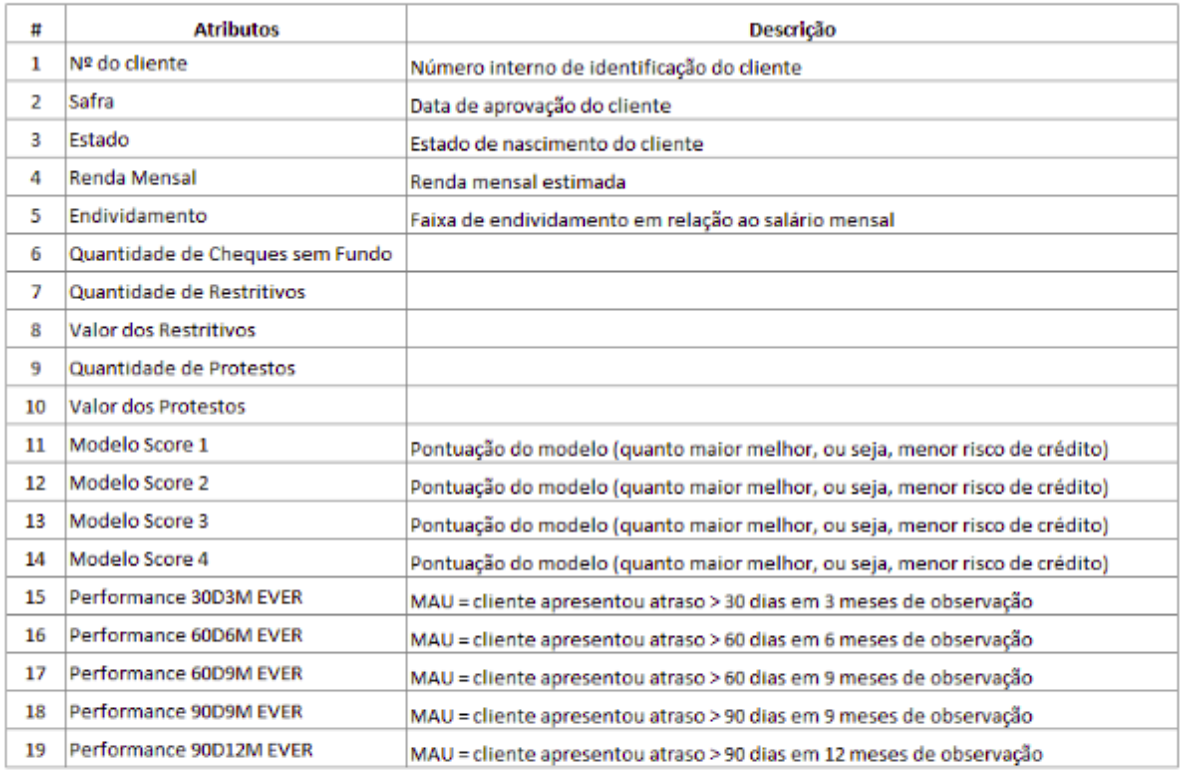

In [27]:
Image('../image/descricao_atributos.png')

# 0.0 Imports

In [18]:
import pickle
import inflection
import random

import pandas     as pd
import numpy      as np
import seaborn    as sns

from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from scipy                 import stats           as ss
from matplotlib            import pyplot          as plt
from scikitplot            import metrics         as mt
from sklearn               import preprocessing   as pp
from sklearn               import linear_model    as lm
from sklearn               import model_selection as ms
from sklearn               import ensemble        as en
from sklearn               import neighbors       as nh
from sklearn               import metrics         as m
from keras                 import models          as ml
from keras                 import layers          as l


import warnings

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [19]:
# Configure notebook visualization
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    #Supress Notatio scientifc
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
jupyter_settings()


#Building cramer 'V'
# from scipy import stats
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values 
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1 ) ) )

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [86]:
# import data

#df_raw = pd.read_csv('../dataset/data_test_DS.csv')
#df_raw.head(5)
df_final = pd.read_csv('../dataset/df_final.csv')
df_final

,Unnamed: 0,renda_mensal,quantidade_de_cheques_sem_fundo,valor_dos_restritivos,quantidade_de_protestos,valor_dos_protestos,modelo_score_1,modelo_score_2,modelo_score_3,modelo_score_4,id_do_cliente,tipo_de_score,compromentimento_da_renda,response
0,5097,0.07,0,321.94,0.00,0.00,250,222,266,666,465006154,1,100,MAU
1,2580,0.07,0,0.00,0.00,0.00,311,623,534,695,997580705,2,25,BOM
2,260,0.05,0,0.00,0.00,0.00,632,647,394,774,289998235,3,25,BOM
3,6781,0.02,0,0.00,0.00,0.00,747,747,718,789,286222838,4,25,BOM
4,5468,0.01,0,0.00,0.00,0.00,253,606,248,598,683857393,1,25,MAU
5,3977,0.10,0,0.00,0.00,0.00,209,576,345,656,278184896,1,25,BOM
6,2834,0.08,0,17.37,0.00,0.00,25,222,156,620,600067937,1,100,BOM
7,4014,0.01,0,0.00,0.00,0.00,335,590,279,701,676915534,2,25,BOM
8,6224,0.07,0,0.00,0.00,0.00,433,617,480,734,579973082,2,25,BOM
9,8001,0.07,0,0.00,0.00,0.00,483,667,499,750,604939417,2,25,BOM


In [4]:
df_raw.columns = df_raw.columns.str.lower().str.replace(' ', '_')
df_raw.columns

Index(['nº_do_cliente', 'safra', 'estado', 'renda_mensal', 'endividamento',
       'quantidade_de_cheques_sem_fundo', 'quantidade_de_restritivos',
       'valor_dos_restritivos', 'quantidade_de_protestos',
       'valor_dos_protestos', 'modelo_score_1', 'modelo_score_2',
       'modelo_score_3', 'modelo_score_4', 'performance_30d3m_ever',
       'performance_60d6m_ever', 'performance_60d9m_ever',
       'performance_90d9m_ever', 'performance_90d12m_ever'],
      dtype='object')

In [5]:
df1 = df_raw

# 1.0 Data Description

## 1.1 Data Dimension

In [6]:
# Visualizamdo o tamanho do dataframe
print('Total of rows: {}' .format(df1.shape[0]))
print('Total of columns: {}' .format(df1.shape[1]))

Total of rows: 11994
Total of columns: 19


## 1.2. Data Types

In [7]:
df1.dtypes

nº_do_cliente                      float64
safra                               object
estado                              object
renda_mensal                       float64
endividamento                       object
quantidade_de_cheques_sem_fundo    float64
quantidade_de_restritivos          float64
valor_dos_restritivos              float64
quantidade_de_protestos            float64
valor_dos_protestos                float64
modelo_score_1                     float64
modelo_score_2                     float64
modelo_score_3                     float64
modelo_score_4                     float64
performance_30d3m_ever              object
performance_60d6m_ever              object
performance_60d9m_ever              object
performance_90d9m_ever              object
performance_90d12m_ever             object
dtype: object

## 1.3. Check NA 

In [8]:
df1.isna().sum()

nº_do_cliente                      1994
safra                              1994
estado                             1994
renda_mensal                       1994
endividamento                      1994
quantidade_de_cheques_sem_fundo    1994
quantidade_de_restritivos          1994
valor_dos_restritivos              1994
quantidade_de_protestos            1994
valor_dos_protestos                1994
modelo_score_1                     1994
modelo_score_2                     1994
modelo_score_3                     1994
modelo_score_4                     1994
performance_30d3m_ever             1994
performance_60d6m_ever             1994
performance_60d9m_ever             3659
performance_90d9m_ever             3659
performance_90d12m_ever            7999
dtype: int64

In [9]:
df1.isna().sum() / len(df1)

nº_do_cliente                     0.17
safra                             0.17
estado                            0.17
renda_mensal                      0.17
endividamento                     0.17
quantidade_de_cheques_sem_fundo   0.17
quantidade_de_restritivos         0.17
valor_dos_restritivos             0.17
quantidade_de_protestos           0.17
valor_dos_protestos               0.17
modelo_score_1                    0.17
modelo_score_2                    0.17
modelo_score_3                    0.17
modelo_score_4                    0.17
performance_30d3m_ever            0.17
performance_60d6m_ever            0.17
performance_60d9m_ever            0.31
performance_90d9m_ever            0.31
performance_90d12m_ever           0.67
dtype: float64

## 1.4. Fillout "NA" (preencher/substituir NA)

In [10]:
# Assumption:
# Decidi eliminar os valores nulos da coluna nº do cliente
# pelo simples motivo de que, se não há dados do clientes não há cliente.
df1 = df1.dropna(subset=['nº_do_cliente'])

## 1.5. Change Types

In [11]:
# Alterar os tipos das variaveis
# safra para datetime
df1['safra'] = pd.to_datetime( df1['safra'] ).dt.strftime( '%Y-%m-%d')
df1['safra'] = pd.to_datetime( df1['safra'] )

#nº_do_cliente para int
df1['id_do_cliente'] = df1['nº_do_cliente'].astype( int )

#'modelo_score_1' para int
df1['modelo_score_1'] = df1['modelo_score_1'].astype(int)
df1['modelo_score_2'] = df1['modelo_score_2'].astype(int)
df1['modelo_score_3'] = df1['modelo_score_3'].astype(int)
df1['modelo_score_4'] = df1['modelo_score_4'].astype(int)


#'quantidade_de_cheques_sem_fundo' para int
df1['quantidade_de_cheques_sem_fundo'] = df1['quantidade_de_cheques_sem_fundo'].astype(int)



In [12]:
df1.head()

,nº_do_cliente,safra,estado,renda_mensal,endividamento,quantidade_de_cheques_sem_fundo,quantidade_de_restritivos,valor_dos_restritivos,quantidade_de_protestos,valor_dos_protestos,modelo_score_1,modelo_score_2,modelo_score_3,modelo_score_4,performance_30d3m_ever,performance_60d6m_ever,performance_60d9m_ever,performance_90d9m_ever,performance_90d12m_ever,id_do_cliente
0,632585066.00,2020-05-01,MS,1076.00,26 a 50%,0,2.00,418.00,0.00,0.00,141,236,196,405,BOM,MAU,MAU,MAU,MAU,632585066
1,1190978461.00,2020-05-01,MG,12709.00,Até 25%,0,0.00,0.00,0.00,0.00,767,646,805,946,BOM,BOM,BOM,BOM,BOM,1190978461
2,1089164529.00,2020-06-01,MS,2518.00,Acima de 100%,0,4.00,32306.00,0.00,0.00,67,238,196,563,BOM,BOM,BOM,BOM,BOM,1089164529
3,134232662.00,2020-05-01,RS,1090.00,Até 25%,0,0.00,0.00,0.00,0.00,245,523,290,698,MAU,BOM,MAU,BOM,MAU,134232662
4,1055185956.00,2020-10-01,RJ,1155.00,Até 25%,0,0.00,0.00,0.00,0.00,697,718,645,816,BOM,BOM,NaN,NaN,NaN,1055185956


## 1.6. Data Descriptive

In [13]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include = ['datetime64[ns]'])

### 1.6.1 Numerical - Users

In [14]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range.
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T #→ range entre min e max

# Grau de assimetria dos dados, skew, kurtosis
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,nº_do_cliente,1241258.00,1218989471.00,1217748213.00,610115364.50,610115364.50,351568784.41,0.00,-1.20
1,renda_mensal,1041.00,33564.00,32523.00,2780.16,3365.00,1464.52,3.95,58.41
2,quantidade_de_cheques_sem_fundo,0.00,64.00,64.00,0.16,0.00,1.56,17.80,458.35
3,quantidade_de_restritivos,-7.00,35.00,42.00,0.71,0.00,1.82,5.49,50.50
4,valor_dos_restritivos,0.00,462266.00,462266.00,1635.66,0.00,10740.69,21.08,691.84
5,quantidade_de_protestos,0.00,37.00,37.00,0.15,0.00,1.17,16.57,362.07
6,valor_dos_protestos,0.00,133742.00,133742.00,209.72,0.00,2700.67,30.00,1169.53
7,modelo_score_1,1.00,999.00,998.00,459.18,481.00,264.00,-0.00,-1.13
8,modelo_score_2,1.00,811.00,810.00,524.18,627.00,200.48,-0.84,-1.00
9,modelo_score_3,1.00,922.00,921.00,483.28,482.00,215.55,0.13,-1.23


**Assumption:**

É perceptivel que, no atributo "modelo_score_4" temos dados particamente normalizados e por esse motivo usarei como atributos para treino do modelo desconsiderando os outros atributos.

Neste ciclo eliminarei os atributos "quantidades_de_restritivos" por apresentar valores negativos.

E para melhoria do modelo, no proximo ciclo deverá re-escalonados os dados para treino por apresentarem outliers.

### 1.6.3. Categorical Attributes

In [15]:
cat_attributes.describe()

,estado,endividamento,performance_30d3m_ever,performance_60d6m_ever,performance_60d9m_ever,performance_90d9m_ever,performance_90d12m_ever
count,10000,10000,10000,10000,8335,8335,3354
unique,10,5,2,2,2,2,2
top,RS,Até 25%,BOM,BOM,BOM,BOM,BOM
freq,1377,7850,8756,8290,6390,6770,2558


In [16]:
# Checking the unique values of each category
cat_attributes.apply(lambda x: x.unique().shape[0])

estado                     10
endividamento               5
performance_30d3m_ever      2
performance_60d6m_ever      2
performance_60d9m_ever      3
performance_90d9m_ever      3
performance_90d12m_ever     3
dtype: int64

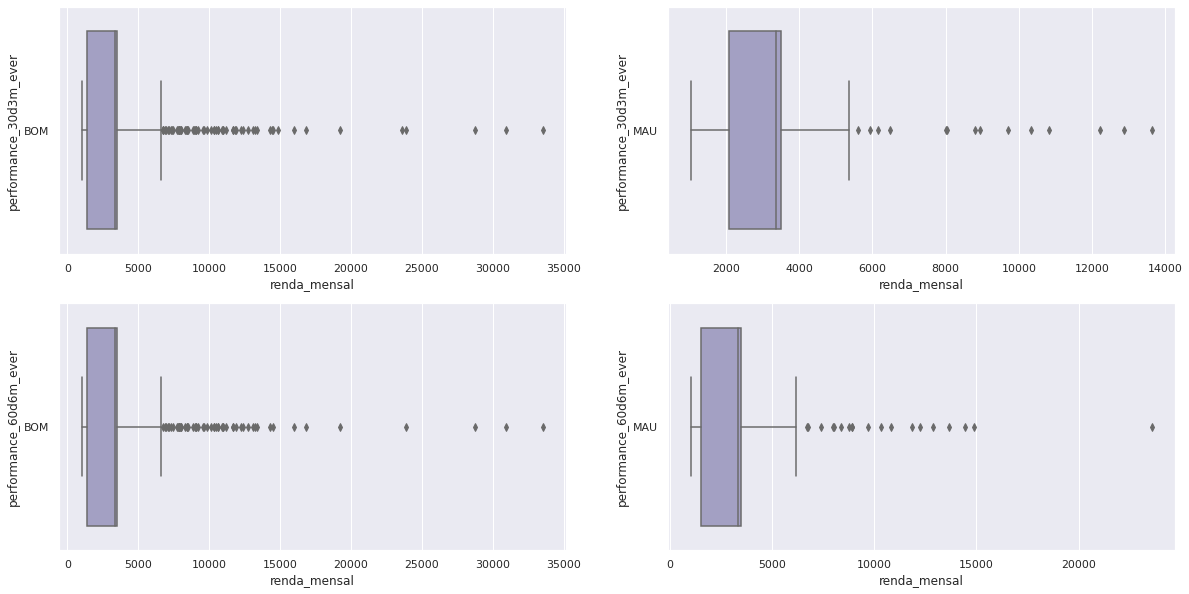

In [17]:
# Filtering the state_holiday category
aux1 = df1[( df1['performance_30d3m_ever'] !='MAU' ) & ( df1['renda_mensal'] >0 )]
aux2 = df1[( df1['performance_30d3m_ever'] !='BOM' ) & ( df1['renda_mensal'] >0 )]
aux3 = df1[( df1['performance_60d6m_ever'] !='MAU' ) & ( df1['renda_mensal'] >0 )]
aux4 = df1[( df1['performance_60d6m_ever'] !='BOM' ) & ( df1['renda_mensal'] >0 )]



plt.subplot(2, 2, 1)
sns.boxplot( y= 'performance_30d3m_ever', x='renda_mensal', data=aux1, palette="Purples_r" );
#
plt.subplot(2, 2, 2)
sns.boxplot( y= 'performance_30d3m_ever', x='renda_mensal', data=aux2, palette="Purples_r" );

#
plt.subplot(2, 2, 3)
sns.boxplot( y= 'performance_60d6m_ever', x='renda_mensal', data=aux3, palette="Purples_r" );

plt.subplot(2, 2, 4)
sns.boxplot( y= 'performance_60d6m_ever', x='renda_mensal', data=aux4, palette="Purples_r" );


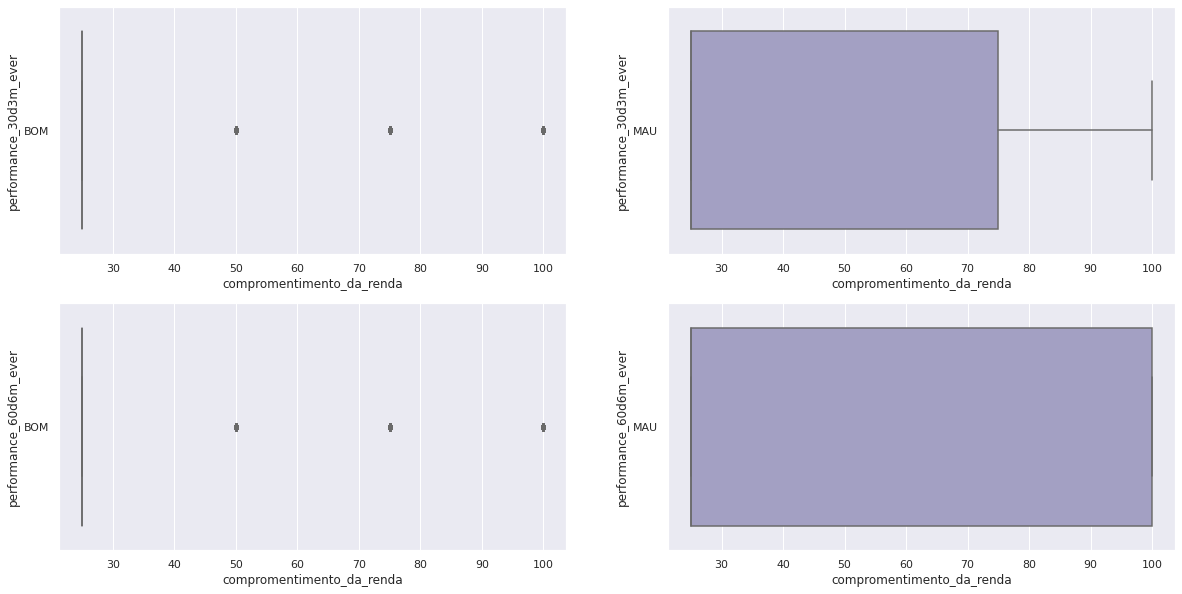

In [28]:
# Filtering performance
aux1 = df2[( df2['performance_30d3m_ever'] !='MAU' ) & ( df2['compromentimento_da_renda'] >0 )]
aux2 = df2[( df2['performance_30d3m_ever'] !='BOM' ) & ( df2['compromentimento_da_renda'] >0 )]
aux3 = df2[( df2['performance_60d6m_ever'] !='MAU' ) & ( df2['compromentimento_da_renda'] >0 )]
aux4 = df2[( df2['performance_60d6m_ever'] !='BOM' ) & ( df2['compromentimento_da_renda'] >0 )]



plt.subplot(2, 2, 1)
sns.boxplot( y= 'performance_30d3m_ever', x='compromentimento_da_renda', data=aux1, palette="Purples_r" );
#
plt.subplot(2, 2, 2)
sns.boxplot( y= 'performance_30d3m_ever', x='compromentimento_da_renda', data=aux2, palette="Purples_r" );

#
plt.subplot(2, 2, 3)
sns.boxplot( y= 'performance_60d6m_ever', x='compromentimento_da_renda', data=aux3, palette="Purples_r" );

plt.subplot(2, 2, 4)
sns.boxplot( y= 'performance_60d6m_ever', x='compromentimento_da_renda', data=aux4, palette="Purples_r" );


In [23]:
# Cramer-V (correlação entre as variaveis)
#Lista de atributos para a correlação de cramer
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        #correlação
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        #apendando o resultado na lista
        corr_list.append(corr)
    # apendando a lista de correlação para cada referencia (atributo)
    corr_dict[ ref ] = corr_list

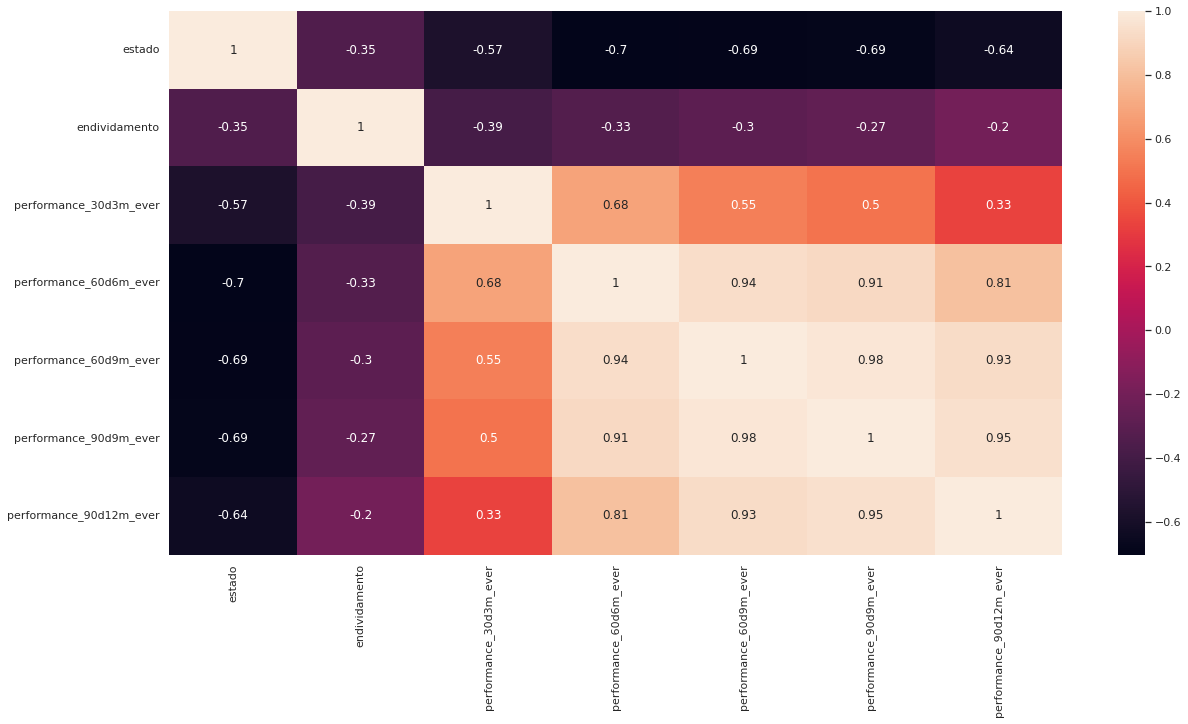

In [24]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)

sns.heatmap( d.corr( method='pearson'), annot=True);

In [25]:
df2 = df1.copy()

# 2.0. Feature Engineering

Quem calcula o score de crédito?
A pontuação de crédito ou score dos consumidores é calculada por birôs de crédito, como a Serasa. Hoje, a solução mais popular do mercado é o Serasa Score, que segue utiliza as seguintes faixas de classificação:

    • de 0 a 300 pontos: ruim;
    • de 301 a 500 pontos: regular;
    • de 501 a 700 pontos: bom;
    • de 701 a 1000 pontos: muito bom.
    
Como o score é calculado?
Conforme já mencionamos, o cálculo do score envolve diferentes fatores. Em geral, são considerados pontos como:

    • Se as contas são pagas em dia;
    • Se existem dívidas ativas no CPF;
    • Frequência com a qual você tenta obter crédito;

_Quais as vantagens de ter um score positivo?: Disponível em: https://www.serasa.com.br/score/blog/vantagens-de-ter-um-score-positivo. Acesso em 18 maio. 2022._

In [26]:
df2.head(2)

,nº_do_cliente,safra,estado,renda_mensal,endividamento,quantidade_de_cheques_sem_fundo,quantidade_de_restritivos,valor_dos_restritivos,quantidade_de_protestos,valor_dos_protestos,modelo_score_1,modelo_score_2,modelo_score_3,modelo_score_4,performance_30d3m_ever,performance_60d6m_ever,performance_60d9m_ever,performance_90d9m_ever,performance_90d12m_ever,id_do_cliente
0,632585066.00,2020-05-01,MS,1076.00,26 a 50%,0,2.00,418.00,0.00,0.00,141,236,196,405,BOM,MAU,MAU,MAU,MAU,632585066
1,1190978461.00,2020-05-01,MG,12709.00,Até 25%,0,0.00,0.00,0.00,0.00,767,646,805,946,BOM,BOM,BOM,BOM,BOM,1190978461


In [27]:
# criar novas features

# Classificar os score's e realizar a normalização dessa feature
df2['tipo_de_score'] = df2['modelo_score_1'].apply(lambda x: 1 if x <300 else 2 if x <500 else 3 if x <700 else 4 )
# de 0 a 300 pontos: ruim; • de 301 a 500 pontos: regular; • de 501 a 700 pontos: bom; • de 701 a 1000 pontos: muito bom.

df2['compromentimento_da_renda'] = df2['endividamento'].apply(lambda x: 25 if x == 'Até 25%' else 50 if x == '26 a 50%' else 75 if x == '51 a 75%' else 100) 

# Ordinal Encoding → Manualmente
value_dict = {'MAU': 1, 'BOM': 0}
df2['performance_de_atraso'] = df2['performance_60d6m_ever'].map(value_dict)



In [30]:
df3 = df2.copy()

# 3.0 Data Preparation

In [32]:
le = LabelEncoder()
mms = MinMaxScaler()
rs = RobustScaler()

#renda mensal
df3['renda_mensal'] = mms.fit_transform(df3[['renda_mensal']].values)
pickle.dump(mms, open('../parameter/renda_mensal_scaler.pkl', 'wb'))

# valor dos restritivos
df3['valor_dos_restritivos'] = rs.fit_transform(df3[['valor_dos_restritivos']].values)
pickle.dump(rs, open('../parameter/valor_dos_restritivos_scaler.pkl', 'wb'))

# valor dos protestos
df3['valor_dos_protestos'] = rs.fit_transform(df3[['valor_dos_protestos']].values)
pickle.dump(rs, open('../parameter/valor_dos_protestos_scaler.pkl', 'wb'))

# Performance de pagamentos
#df3['performance_60d6m_ever'] = le.fit_transform( df3['performance_60d6m_ever'] )
#pickle.dump(le, open('../parameter/performance_60d6m_ever_scaler.pkl', 'wb'))


In [35]:
df4 = df3.copy()

# 4.0 Feature Selection

## 4.1 Univariate Analysis

In [144]:
df4.dtypes

nº_do_cliente                               int64
safra                              datetime64[ns]
estado                                     object
renda_mensal                              float64
endividamento                              object
quantidade_de_cheques_sem_fundo             int64
quantidade_de_restritivos                 float64
valor_dos_restritivos                     float64
quantidade_de_protestos                   float64
valor_dos_protestos                       float64
modelo_score_1                              int64
modelo_score_2                              int64
modelo_score_3                              int64
modelo_score_4                              int64
performance_30d3m_ever                     object
performance_60d6m_ever                      int64
performance_60d9m_ever                     object
performance_90d9m_ever                     object
performance_90d12m_ever                    object
id_do_cliente                               int64


### 4.1.1. Comprometimento da Renda X Score

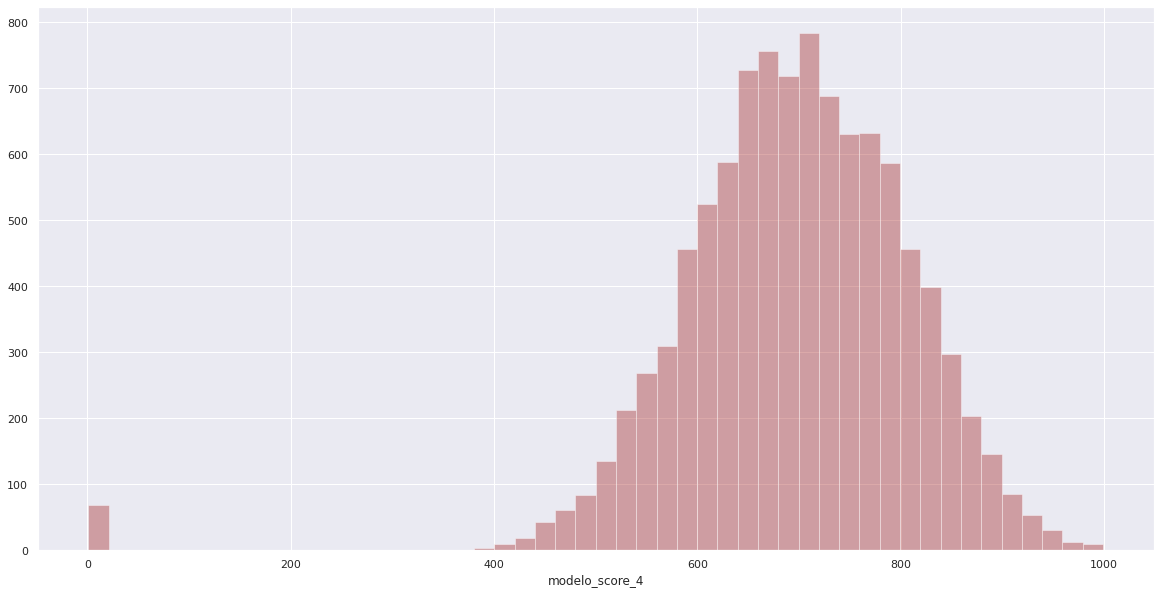

In [118]:
# Analyzing "modelo_score_4" behavior
sns.distplot( df4['modelo_score_4'] , kde=False, color='brown');

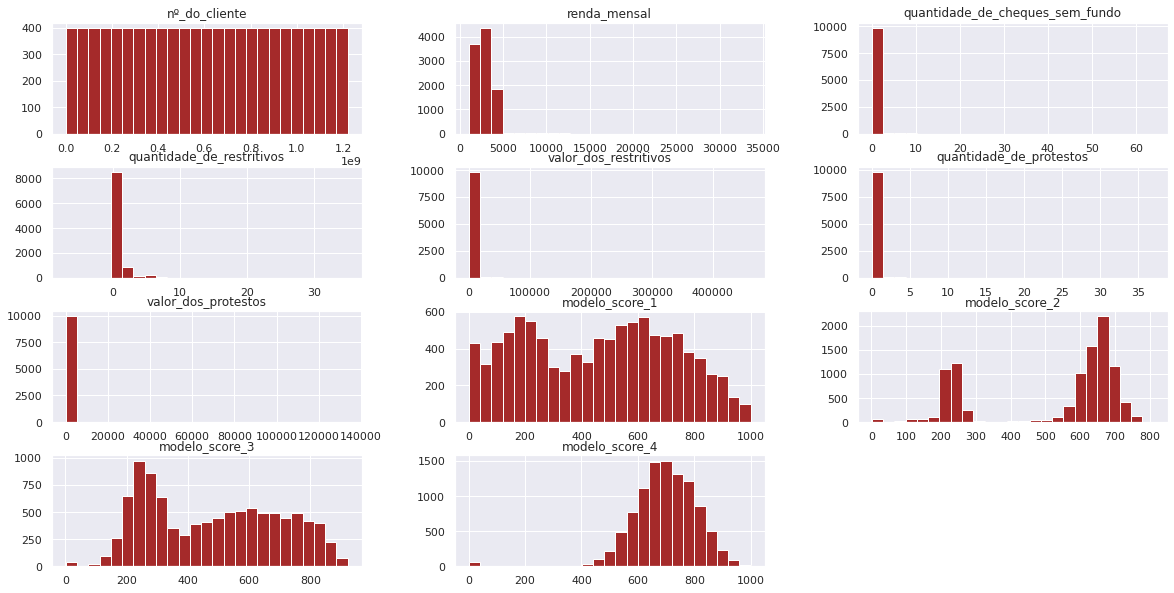

In [119]:
num_attributes.hist(bins=25, color='brown');
plt.rcParams['figure.figsize'] = [40, 20]

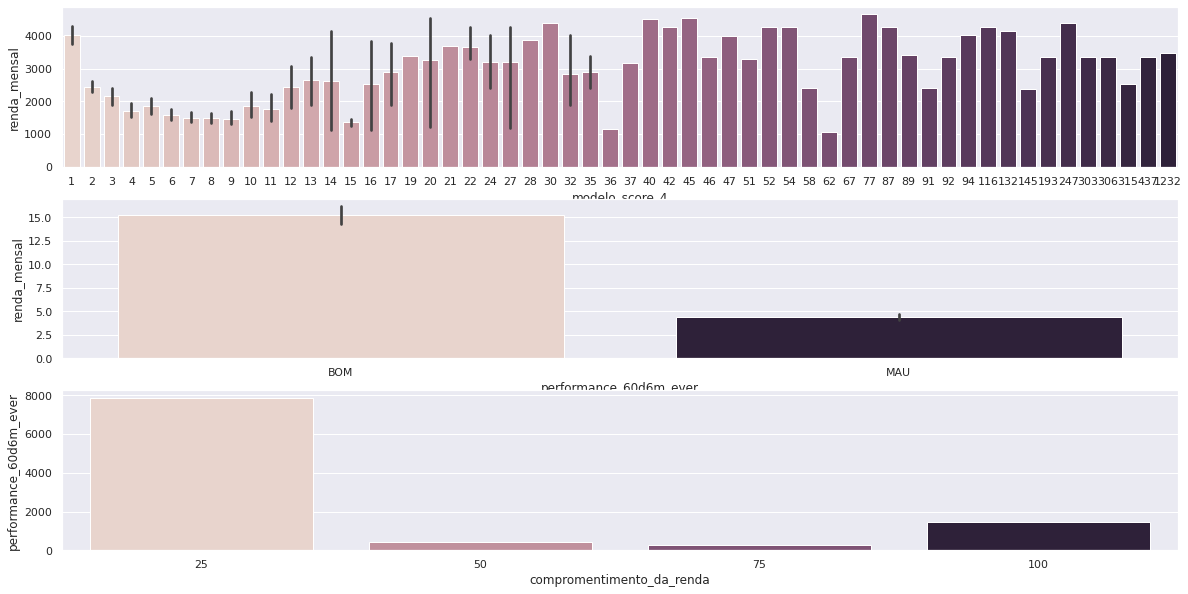

In [31]:

# Agrupamento o score pela renda mensal
aux1 = df1[['modelo_score_4', 'renda_mensal']].groupby('renda_mensal').count().reset_index()
plt.subplot(3, 1, 1)
sns.barplot(x='modelo_score_4', y='renda_mensal', data=aux1,  palette="ch:.05");

# visualizando as performance do ususario em relação a renda mensal
aux2 = df2[['performance_60d6m_ever','modelo_score_4', 'renda_mensal']].groupby(['performance_60d6m_ever','modelo_score_4']).count().reset_index()
plt.subplot(3, 1, 2)
sns.barplot(x='performance_60d6m_ever', y='renda_mensal', hue=None, data=aux2, palette="ch:.05");


aux3 = df2[['performance_60d6m_ever','compromentimento_da_renda']].groupby(['compromentimento_da_renda']).count().reset_index()
plt.subplot(3, 1, 3)
sns.barplot( y= 'performance_60d6m_ever', x='compromentimento_da_renda', data=aux3, palette="ch:.05" );


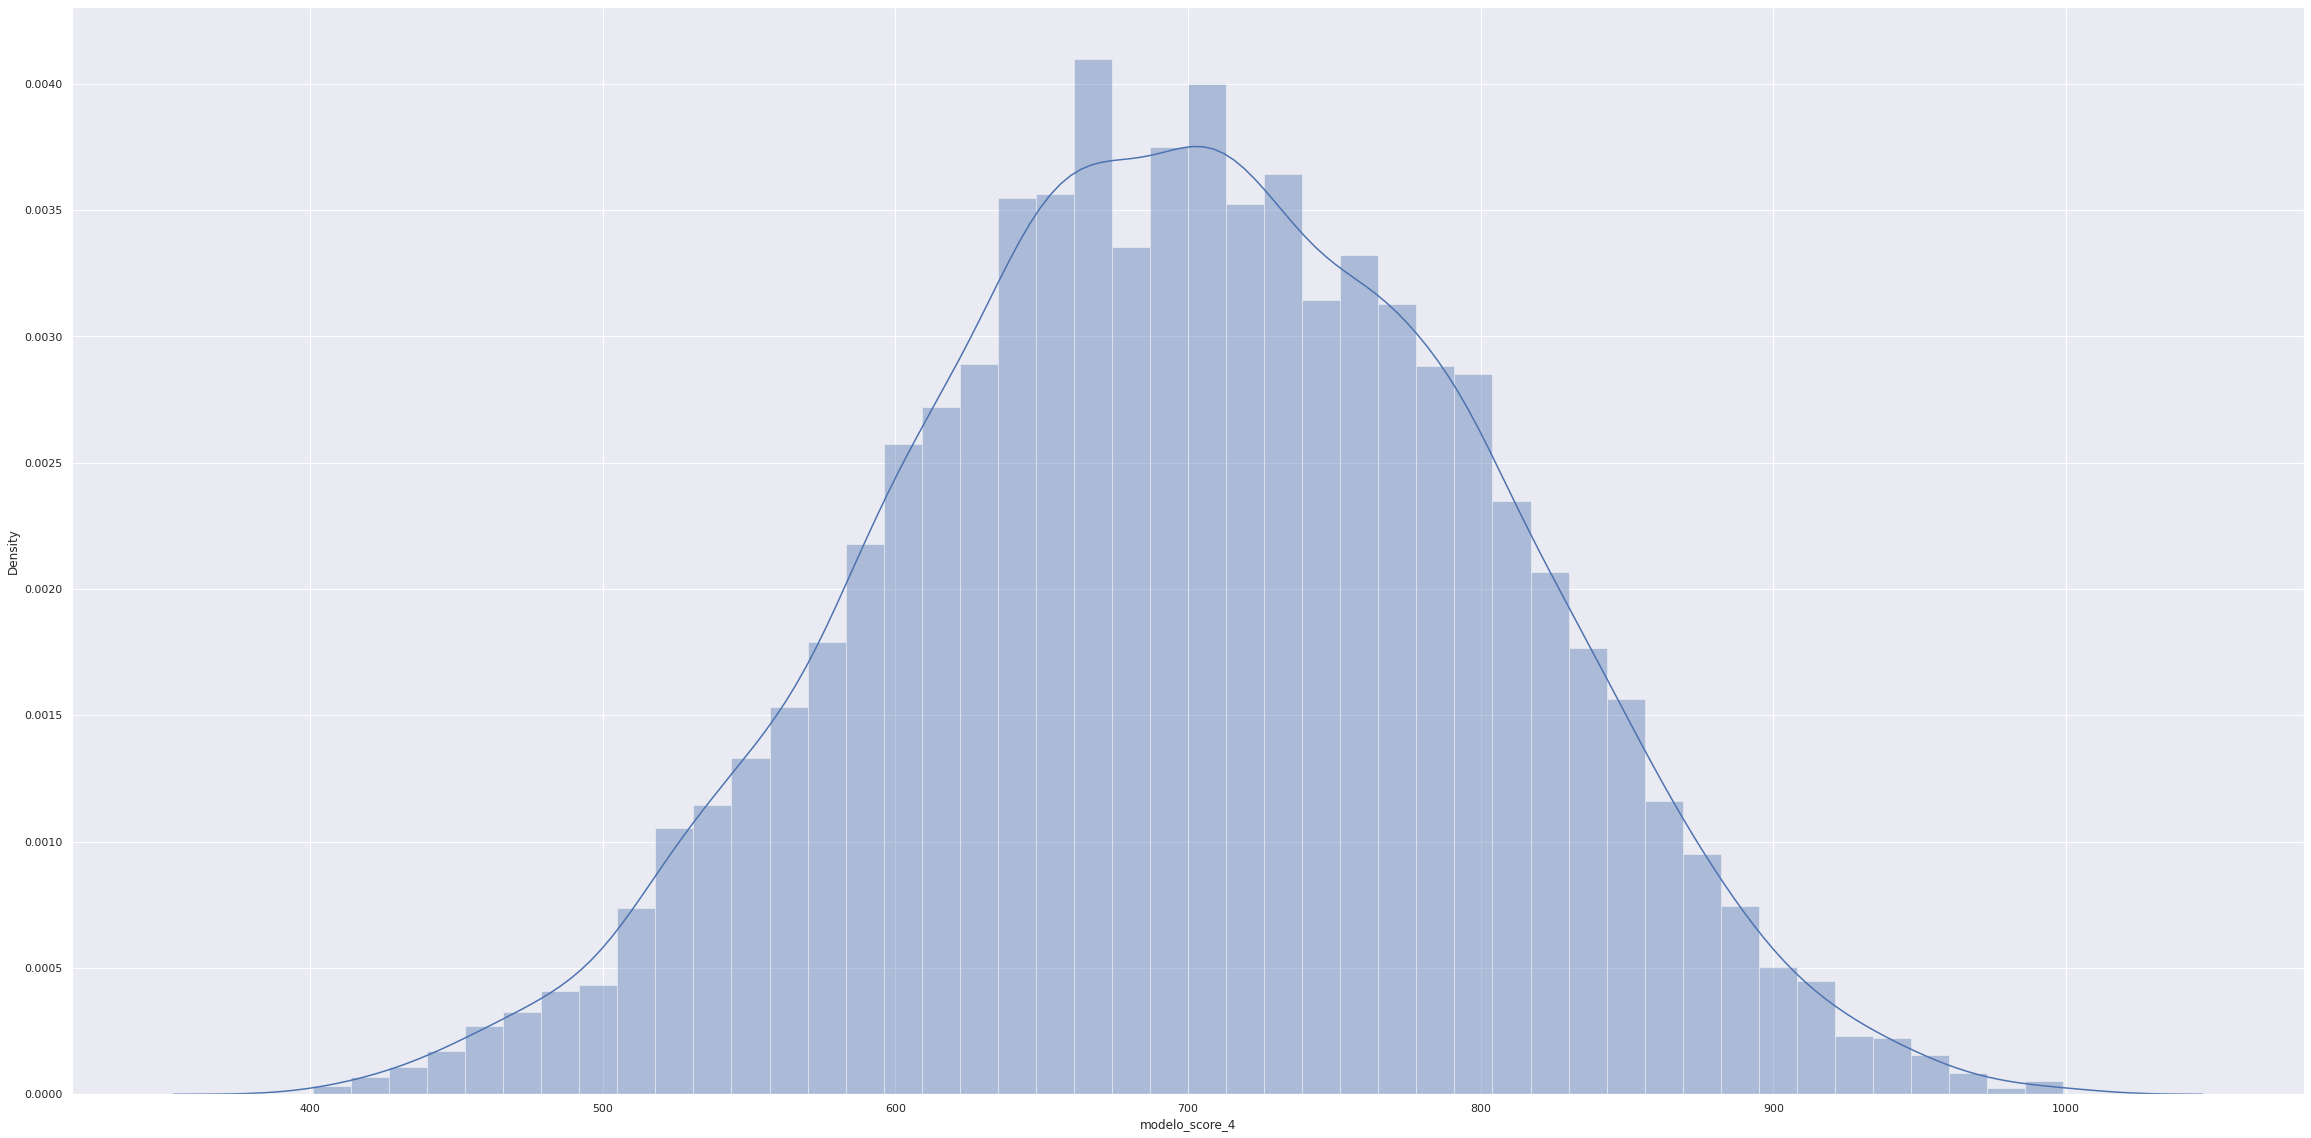

In [122]:
# Distribuição do atributo score 4
sns.distplot(df4[df4['modelo_score_4']>400]['modelo_score_4']);

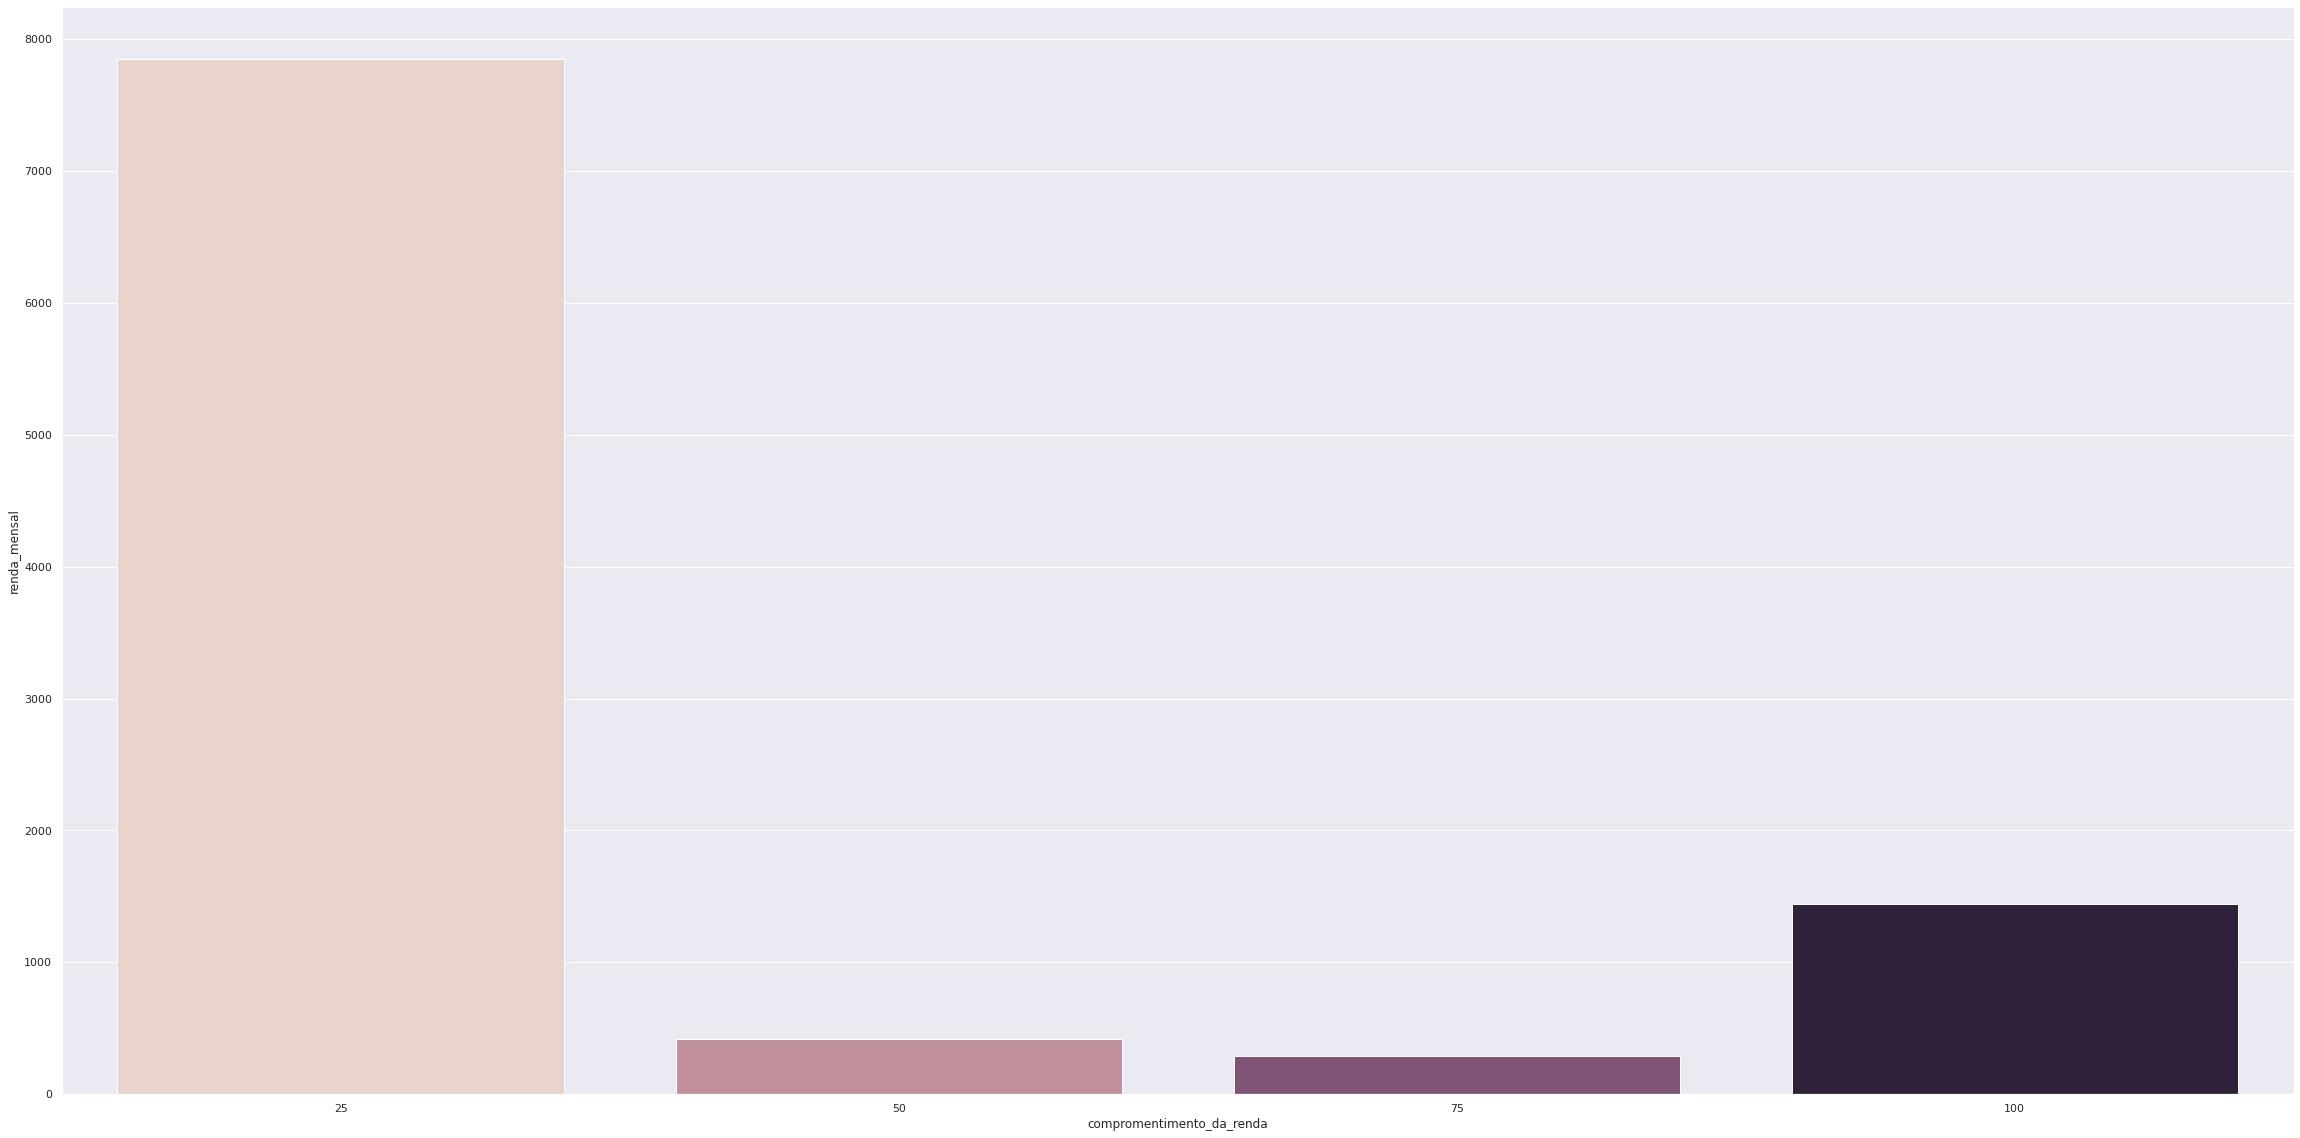

In [123]:

aux=df4[df4['modelo_score_4']!=0]
aux=aux[['compromentimento_da_renda', 'modelo_score_4', 'renda_mensal']].groupby('compromentimento_da_renda').size().reset_index().rename(columns={0:'renda_mensal'})
ax=sns.barplot(data=aux, x='compromentimento_da_renda', y='renda_mensal', palette="ch:.05");
total=sum(aux['renda_mensal'])


In [124]:
df4.head()

,nº_do_cliente,safra,estado,renda_mensal,endividamento,quantidade_de_cheques_sem_fundo,quantidade_de_restritivos,valor_dos_restritivos,quantidade_de_protestos,valor_dos_protestos,modelo_score_1,modelo_score_2,modelo_score_3,modelo_score_4,performance_30d3m_ever,performance_60d6m_ever,performance_60d9m_ever,performance_90d9m_ever,performance_90d12m_ever,tipo_de_score,compromentimento_da_renda,performance_de_atraso
0,632585066,2020-05-01,MS,0.00,26 a 50%,0,2.00,2.88,0.00,0.00,141,236,196,405,BOM,1,MAU,MAU,MAU,1,50,1
1,1190978461,2020-05-01,MG,0.36,Até 25%,0,0.00,0.00,0.00,0.00,767,646,805,946,BOM,0,BOM,BOM,BOM,4,25,0
2,1089164529,2020-06-01,MS,0.05,Acima de 100%,0,4.00,222.80,0.00,0.00,67,238,196,563,BOM,0,BOM,BOM,BOM,1,100,0
3,134232662,2020-05-01,RS,0.00,Até 25%,0,0.00,0.00,0.00,0.00,245,523,290,698,MAU,0,MAU,BOM,MAU,1,25,0
4,1055185956,2020-10-01,RJ,0.00,Até 25%,0,0.00,0.00,0.00,0.00,697,718,645,816,BOM,0,NaN,NaN,NaN,3,25,0


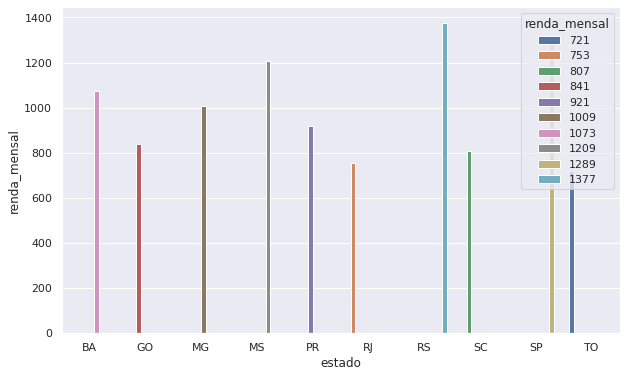

In [125]:
#plt.figure(figsize(10,6))
#df4 = df4[(df4['renda_mensal']) & (df4['estado'])]
#aux0 = df4.loc[df4['modelo_score_1'] >= 300, 'comprometimento_da_renda']
#sns.histplot(aux0)

aux0 = df4[['renda_mensal', 'estado']].groupby(['estado']).count().reset_index()
plt.figure(figsize(10,6))
sns.barplot(x = 'estado', y = 'renda_mensal', hue = 'renda_mensal', data = aux0);

# 5.0. Machine Learning Model - Neural Network MLP

In [45]:
cols_drop = ['nº_do_cliente', 'estado', 'endividamento', 'safra', 'quantidade_de_restritivos',
             'performance_30d3m_ever', 'performance_60d9m_ever',
             'performance_90d9m_ever', 'performance_90d12m_ever',
             'performance_de_atraso'] 
df5 = df4.drop(cols_drop, axis=1)

In [37]:
df5.columns

Index(['renda_mensal', 'quantidade_de_cheques_sem_fundo',
       'valor_dos_restritivos', 'quantidade_de_protestos',
       'valor_dos_protestos', 'modelo_score_1', 'modelo_score_2',
       'modelo_score_3', 'modelo_score_4', 'performance_60d6m_ever',
       'id_do_cliente', 'tipo_de_score', 'compromentimento_da_renda'],
      dtype='object')

In [46]:
X = df5.drop('performance_60d6m_ever', axis=1)
y = df5['performance_60d6m_ever'].copy()

In [47]:
#split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.3, random_state=32 )

In [41]:
x_train = X_train.drop('id_do_cliente', axis=1)
x_test = X_test.drop('id_do_cliente', axis=1)

## 5.1. Baseline Model

In [176]:
#target_payment_list

In [42]:
#para descobrir os pesos
df1['performance_60d6m_ever'].value_counts(normalize=True).sort_index().tolist()

[0.829, 0.171]

In [58]:
import random
# Tamanho da população ou amostragem
target_payment_list = df1['performance_60d6m_ever'].drop_duplicates().sort_values().tolist()

# amostragem 
k_num = y_test.shape[0]

# para descobrir os pesos
target_payment_weights = df1['performance_60d6m_ever'].value_counts(normalize=True).sort_index().tolist()

# Predição aleatoria
yhat_random = random.choices(population=target_payment_list,
                             weights=target_payment_weights,
                             k=k_num)
len(yhat_random)

3000

Accuracy: 0.708
Balanced accuracy: 0.5005636134668392
Kappa Score: 0.001167584923559728
              precision    recall  f1-score   support

         BOM       0.81      0.83      0.82      2442
         MAU       0.19      0.17      0.18       558

    accuracy                           0.71      3000
   macro avg       0.50      0.50      0.50      3000
weighted avg       0.70      0.71      0.70      3000



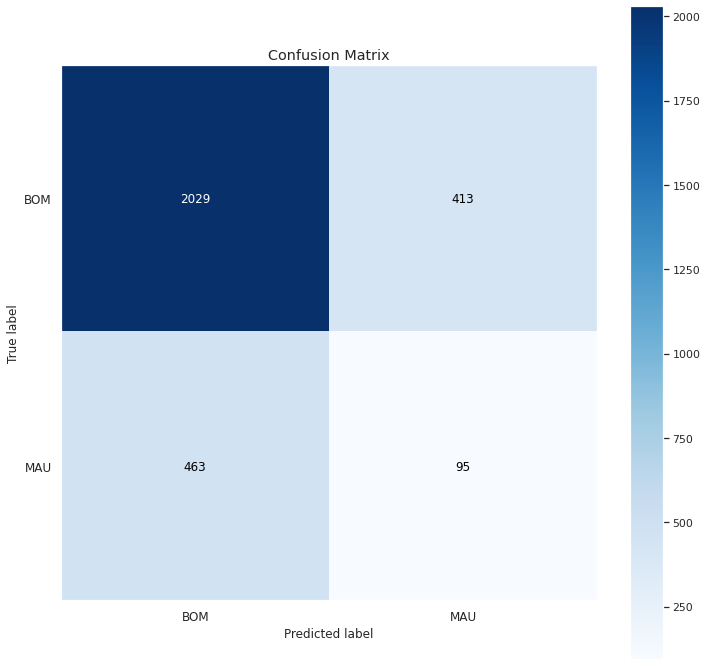

In [59]:
#Otpimizando o modelo para garantir uma a=metrica mais segura

# Accuracy → medindo a acuracia da predição
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

#Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(m.classification_report(y_test, yhat_random))

# confusion matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

#yhat_nn

## 5.2. Neural Network - MLP

In [60]:
# One_hot_enconding → rede neural
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()
#transformando o y_train (series) em lista de array
#transformando o y_train (series) em lista de array
#y_train.values.reshape(-1, 1)

In [49]:
y_train_nn

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [50]:
#Model Definition

model = ml.Sequential()

#definindo o tamanho do modelo
model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(2, activation='softmax' ))

#model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#train model
model.fit(x_train, y_train_nn, epochs=200)

2022-05-20 15:12:49.739275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-20 15:12:49.739309: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-20 15:12:49.739336: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-05-20 15:12:49.739732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
219/219 [==============================] - 1s 1ms/step - loss: 10.8362 - accuracy: 0.7443
Epoch 2/200
219/219 [==============================] - 0s 1ms/step - loss: 8.5404 - accuracy: 0.7520
Epoch 3/200
219/219 [==============================] - 0s 1ms/step - loss: 7.3616 - accuracy: 0.7597
Epoch 4/200
219/219 [==============================] - 0s 1ms/step - loss: 7.1109 - accuracy: 0.7534
Epoch 5/200
219/219 [==============================] - 0s 1ms/step - loss: 7.1002 - accuracy: 0.7636
Epoch 6/200
219/219 [==============================] - 0s 1ms/step - loss: 4.2128 - accuracy: 0.7580
Epoch 7/200
219/219 [==============================] - 0s 1ms/step - loss: 8.8104 - accuracy: 0.7654
Epoch 8/200
219/219 [==============================] - 0s 1ms/step - loss: 6.7964 - accuracy: 0.7670
Epoch 9/200
219/219 [==============================] - 0s 1ms/step - loss: 7.0375 - accuracy: 0.7530
Epoch 10/200
219/219 [==============================] - 0s 1ms/step - loss: 4.1562 - accur

219/219 [==============================] - 0s 1ms/step - loss: 0.4113 - accuracy: 0.8349
Epoch 161/200
219/219 [==============================] - 0s 1ms/step - loss: 0.4090 - accuracy: 0.8360
Epoch 162/200
219/219 [==============================] - 0s 1ms/step - loss: 0.4086 - accuracy: 0.8360
Epoch 163/200
219/219 [==============================] - 0s 1ms/step - loss: 0.4080 - accuracy: 0.8353
Epoch 164/200
219/219 [==============================] - 0s 1ms/step - loss: 0.4092 - accuracy: 0.8360
Epoch 165/200
219/219 [==============================] - 0s 1ms/step - loss: 0.4104 - accuracy: 0.8360
Epoch 166/200
219/219 [==============================] - 0s 1ms/step - loss: 0.4103 - accuracy: 0.8359
Epoch 167/200
219/219 [==============================] - 0s 1ms/step - loss: 0.4098 - accuracy: 0.8354
Epoch 168/200
219/219 [==============================] - 0s 1ms/step - loss: 0.4107 - accuracy: 0.8360
Epoch 169/200
219/219 [==============================] - 0s 1ms/step - loss: 0.4084 - a

## 5.1. NN Performance

In [51]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction → retornando a variavel resposta para o formato original
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

94/94 [==============================] - 0s 712us/step


Accuracy: 0.8126666666666666
Balanced Accuracy: 0.4991809991809992
Kappa Score: -0.002654715688513498
              precision    recall  f1-score   support

         BOM       0.81      1.00      0.90      2442
         MAU       0.00      0.00      0.00       558

    accuracy                           0.81      3000
   macro avg       0.41      0.50      0.45      3000
weighted avg       0.66      0.81      0.73      3000



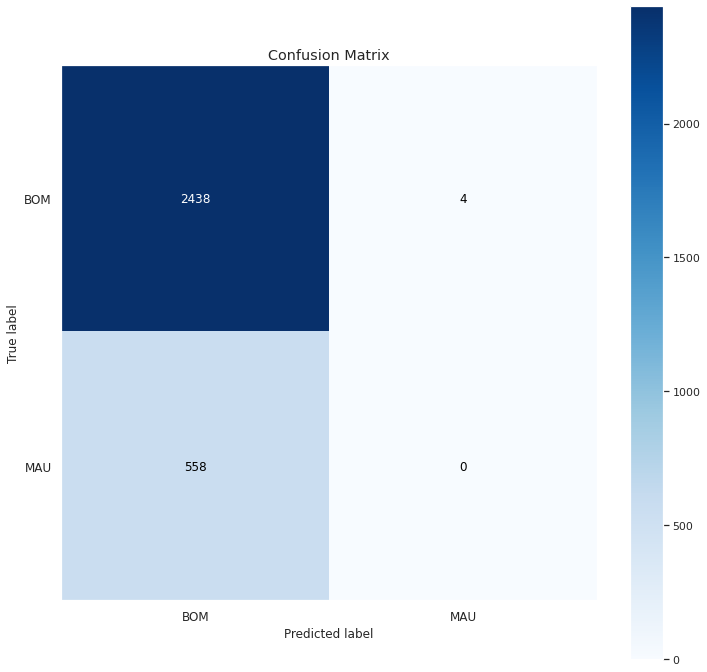

In [52]:
# Nesse tipo de problema, a "acuracia" não é uma metrica confiavel para analisar a predição
# poís considera o desbalanceamento do dataframe

# Accuracy → medindo a acuracia da predição
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

#Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification Report
print(m.classification_report(y_test_nn, yhat_nn))

# confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

#yhat_nn

## 5.2.0 NN Performance - Cross-validation

In [56]:
# K-fold → replicando os testes
num_fold = 5
kfold = ms.StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i= 1
#captura as proporções dos dados para cada um dos folds
for train_ix, val_ix in kfold.split(x_train, y_train):
    print('Fold number: {} / {}'.format(i, num_fold))
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    # get val
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # Encoding target
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray() #→transform um array
        
    
    # model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation='relu'))
    model.add(l.Dense(2, activation='softmax'))

    #Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    #training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=200, batch_size=32, verbose=0)
    
    # Prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn) #→retorna o valor original
    
    # Prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]
    
    #
    
    # Balanced Accuracy Score
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    # kappa Score
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i += 1
    




Fold number: 1 / 5
44/44 [==============================] - 0s 778us/step
Fold number: 2 / 5
44/44 [==============================] - 0s 1ms/step
Fold number: 3 / 5
44/44 [==============================] - 0s 863us/step
Fold number: 4 / 5
44/44 [==============================] - 0s 871us/step
Fold number: 5 / 5
44/44 [==============================] - 0s 895us/step


In [57]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.round(np.mean(balanced_acc_list), 4), np.round(np.std(balanced_acc_list), 4)))
print('Avg Kappa Score: {} +/- {}'.format(np.round(np.mean(kappa_acc_list), 4), np.round(np.std(kappa_acc_list), 4)))

Avg Balanced Accuracy: 0.5007 +/- 0.0011
Avg Kappa Score: 0.0023 +/- 0.0035


**Analisando as métricas de validação do modelo:**

Ambos as metricas de validação _balanced Accuracy_ e o _Kappa Score_ me mostram que no cenário atual meu modelo performou de forma aleatoria e pouco acertivas!

**Solução:**

Elaborar no proximo ciclo o balanceamento dos dados, atribuição de maiores informações ao dados e elaborando melhores tratamentos e _feature engineering_.

## Resultado do modelo anterior ao features engineering

* Avg Balanced Accuracy: 0.5001 +/- 0.0007
* Avg Kappa Score: 0.0005 +/- 0.0023

## Resultado do modelo após o features engineering

* Avg Balanced Accuracy: 0.5005 +/- 0.0007
* Avg Kappa Score: 0.0017 +/- 0.0024

## Resultado do modelo após a normalização e re-escala dos dados

* Avg Balanced Accuracy: 0.501 +/- 0.0019
* Avg Kappa Score: 0.0032 +/- 0.0062

## Resultado do modelo após otimizar o tamanho do conjunto de treino e reescala dos dados

* Avg Balanced Accuracy: 0.5007 +/- 0.0011
* Avg Kappa Score: 0.0023 +/- 0.0035